Импорты используемых библиотек:

In [186]:
import os
import re
import nltk
import umap
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn import model_selection
import matplotlib.patches as mpatches
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from tensorflow.keras import models, layers, preprocessing as kprocessing, Sequential

import smart_open
smart_open.open = smart_open.smart_open
import gensim
import gensim.downloader as gensim_api

import multiprocessing

Функция для преобразования текста (удаление стоп-слов, стемминг и лемматизация):

In [105]:
counter=CountVectorizer(
        token_pattern=r"[A-Za-zА-Яа-яЁё]+\-[A-Za-zА-Яа-яЁё]+|[A-Za-zА-Яа-яЁё]+", 
        stop_words="english")

def get_most_freq_words(text, count=-1):
    try:
        res=counter.fit_transform([text])
    except ValueError:
        return None
    
    frq = sorted([(i, res[0,i]) for i in range(res[0].shape[1])], 
                 key = lambda x: x[1], reverse = True)[:count]
    vocab = {w:res[0,i] for w,i in counter.vocabulary_.items()}
    return [[w for w, n in counter.vocabulary_.items() if n==i][0] 
            for i, f in frq]

In [111]:
def normalize(text):
    words = get_most_freq_words(text)
    
    if not words:
        words = re.findall('[A-Za-zА-Яа-яЁё]+\-[A-Za-zА-Яа-яЁё]+|[A-Za-zА-Яа-яЁё]+', text)
        sw = stopwords.words('english')
        lst_text = [word for word in words if word not in sw][:1001]

    # Стемминг
    ps = nltk.stem.porter.PorterStemmer()
    words = [ps.stem(word) for word in words]

    # Лемматизация
    # lem = nltk.stem.wordnet.WordNetLemmatizer()
    # words = [lem.lemmatize(word) for word in words]

    return " ".join(words)

nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\qwerf\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\qwerf\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [80]:
biology = pd.read_excel("../data/articles/Biology.xlsx").dropna().head(500)
biology["class"] = "biology"
arts = pd.read_excel("../data/articles/Arts.xlsx").dropna().head(500)
arts["class"] = "arts"
chemistry = pd.read_excel("../data/articles/Chemistry.xlsx").dropna().head(500)
chemistry["class"] = "chemistry"
evolution = pd.read_excel("../data/articles/Evolution.xlsx").dropna().head(500)
evolution["class"] = "evolution"
math = pd.read_excel("../data/articles/Math.xlsx").dropna().head(500)
math["class"] = "math"
physics = pd.read_excel("../data/articles/Physics.xlsx").dropna().head(500)
physics["class"] = "physics"
policy_ethics = pd.read_excel("../data/articles/PolicyEthics.xlsx").dropna().head(500)
policy_ethics["class"] = "policy_ethics"
articles = pd.concat([biology, arts, chemistry, evolution, math, physics, policy_ethics])

In [91]:
articles

,text,title,class
0,This spring’s emergence of periodical cicadas ...,Brood X Cicadas Could Cause a Bird Baby Boom,biology
1,"In the 1980s, scientists discovered that oyste...",How a Carnivorous Mushroom Poisons Its Prey,biology
2,"In September 2017, when Hurricane Maria hit Pu...",What Monkeys Can Teach Humans about Resilience...,biology
3,A few plants in the cabbage and mustard family...,Killer Leaves Emerge from Plant-Butterfly Arms...,biology
4,The following essay is reprinted with permissi...,Chocolate’s Secret Ingredient Is Fermenting Mi...,biology
...,...,...,...
548,"No one thinks, I am the kind of person who is ...",Everyone Is an Agent in the New Information Wa...,policy_ethics
549,Just weeks after NASA’s Europa Clipper mission...,NASA Has Committed to a Rocket for the Europa ...,policy_ethics
550,In an apparent disappointment for President Tr...,What Greenland Might Have Taught Trump about W...,policy_ethics
551,Science and engineering have given us physical...,Our Ethics Must Catch Up with Our Increasingly...,policy_ethics


In [82]:
articles.columns = ["text", "title", "class"]
articles = articles.dropna()
articles

,text,title,class
0,This spring’s emergence of periodical cicadas ...,Brood X Cicadas Could Cause a Bird Baby Boom,biology
1,"In the 1980s, scientists discovered that oyste...",How a Carnivorous Mushroom Poisons Its Prey,biology
2,"In September 2017, when Hurricane Maria hit Pu...",What Monkeys Can Teach Humans about Resilience...,biology
3,A few plants in the cabbage and mustard family...,Killer Leaves Emerge from Plant-Butterfly Arms...,biology
4,The following essay is reprinted with permissi...,Chocolate’s Secret Ingredient Is Fermenting Mi...,biology
...,...,...,...
548,"No one thinks, I am the kind of person who is ...",Everyone Is an Agent in the New Information Wa...,policy_ethics
549,Just weeks after NASA’s Europa Clipper mission...,NASA Has Committed to a Rocket for the Europa ...,policy_ethics
550,In an apparent disappointment for President Tr...,What Greenland Might Have Taught Trump about W...,policy_ethics
551,Science and engineering have given us physical...,Our Ethics Must Catch Up with Our Increasingly...,policy_ethics


In [112]:
articles["cleaned"] = articles.text.apply(lambda text: normalize(text))

In [113]:
articles

,text,title,class,cleaned
0,This spring’s emergence of periodical cicadas ...,Brood X Cicadas Could Cause a Bird Baby Boom,biology,cicada cicada speci popul say year year s bird...
1,"In the 1980s, scientists discovered that oyste...",How a Carnivorous Mushroom Poisons Its Prey,biology,s nematod nematod poison worm calcium fungi sc...
2,"In September 2017, when Hurricane Maria hit Pu...",What Monkeys Can Teach Humans about Resilience...,biology,social s say macaqu platt santiago island monk...
3,A few plants in the cabbage and mustard family...,Killer Leaves Emerge from Plant-Butterfly Arms...,biology,plant egg speci butterfli famili plant say but...
4,The following essay is reprinted with permissi...,Chocolate’s Secret Ingredient Is Fermenting Mi...,biology,chocol ferment bean cacao s bacteria flavor pr...
...,...,...,...,...
548,"No one thinks, I am the kind of person who is ...",Everyone Is an Agent in the New Information Wa...,policy_ethics,disinform inform misinform twitter way agenc a...
549,Just weeks after NASA’s Europa Clipper mission...,NASA Has Committed to a Rocket for the Europa ...,policy_ethics,europa s clipper sl launch mission nasa say ap...
550,In an apparent disappointment for President Tr...,What Greenland Might Have Taught Trump about W...,policy_ethics,s greenland ice melt climat island sheet trump...
551,Science and engineering have given us physical...,Our Ethics Must Catch Up with Our Increasingly...,policy_ethics,s human nuclear ethic nobel today year evolut ...


In [194]:
train, test = model_selection.train_test_split(articles, test_size=0.2)

Строим из преобразованных текстов n-граммы:

In [115]:
corpus = train["cleaned"]

# Сформируем список юниграмм
lst_corpus = []
for string in corpus:
   lst_words = string.split()
   lst_grams = [" ".join(lst_words[i:i+1]) 
               for i in range(0, len(lst_words), 1)]
   lst_corpus.append(lst_grams)

# Детекторы для биграмм и триграмм
bigrams_detector = gensim.models.phrases.Phrases(lst_corpus, 
                 delimiter=" ".encode(), min_count=5, threshold=10)
bigrams_detector = gensim.models.phrases.Phraser(bigrams_detector)
trigrams_detector = gensim.models.phrases.Phrases(bigrams_detector[lst_corpus], 
            delimiter=" ".encode(), min_count=5, threshold=10)
trigrams_detector = gensim.models.phrases.Phraser(trigrams_detector)

Обучаем модель Word2Vec для построения вложений слов:

In [116]:
nlp = gensim.models.word2vec.Word2Vec(lst_corpus, size=50,   
            window=8, min_count=1, sg=1, iter=10)

In [117]:
nlp["data"]

<ipython-input-117-1c886153b0de>:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  nlp["data"]


array([ 0.5374022 ,  0.13813786, -0.4022556 , -0.15778375,  0.42985624,
        0.31883025, -0.12344817,  0.47533414, -0.4574097 ,  0.09873041,
        0.2849262 ,  0.61119646,  0.2824793 ,  0.1203637 , -0.29428604,
       -0.01226385, -0.43083307,  0.6764993 , -0.2627169 ,  0.00989665,
        0.03792951, -1.197182  ,  0.06158241, -0.03190647, -0.3096349 ,
       -0.66634697,  1.4498439 ,  0.18043733, -0.13272913,  0.42041522,
        0.05601891, -0.7360847 ,  0.14068376,  0.15048191, -0.1356001 ,
       -1.1772099 ,  0.33412477,  0.11815573, -0.08053003, -1.140121  ,
        0.4626045 , -0.16571333, -0.42245582, -0.11251492, -0.02571745,
       -0.39686617,  0.40502042,  0.31262594,  0.23973377, -0.18736061],
      dtype=float32)

Преобразование текста в вектор чисел на основе построенных с помощью word2Vec вложений слов:

In [118]:
def text_to_vec(text):
    words = text.split(" ")
    vec = [nlp[word] for word in words if word in nlp.wv.vocab]
    return np.asarray(vec).reshape(-1)

In [119]:
articles["vec"] = articles.cleaned.apply(lambda text: text_to_vec(text))

<ipython-input-118-71e452b38b9e>:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vec = [nlp[word] for word in words if word in nlp.wv.vocab]


In [120]:
articles

,text,title,class,cleaned,vec
0,This spring’s emergence of periodical cicadas ...,Brood X Cicadas Could Cause a Bird Baby Boom,biology,cicada cicada speci popul say year year s bird...,"[0.52681154, 0.06969545, -0.36882672, 0.733362..."
1,"In the 1980s, scientists discovered that oyste...",How a Carnivorous Mushroom Poisons Its Prey,biology,s nematod nematod poison worm calcium fungi sc...,"[1.3348258, 0.8364394, -0.3081714, -0.8926584,..."
2,"In September 2017, when Hurricane Maria hit Pu...",What Monkeys Can Teach Humans about Resilience...,biology,social s say macaqu platt santiago island monk...,"[0.40816787, 0.41115835, 0.58864635, 0.1728889..."
3,A few plants in the cabbage and mustard family...,Killer Leaves Emerge from Plant-Butterfly Arms...,biology,plant egg speci butterfli famili plant say but...,"[0.3843866, 0.73506266, 0.20442915, 0.639453, ..."
4,The following essay is reprinted with permissi...,Chocolate’s Secret Ingredient Is Fermenting Mi...,biology,chocol ferment bean cacao s bacteria flavor pr...,"[0.30491006, 0.37300158, 0.041364893, 0.739714..."
...,...,...,...,...,...
548,"No one thinks, I am the kind of person who is ...",Everyone Is an Agent in the New Information Wa...,policy_ethics,disinform inform misinform twitter way agenc a...,"[-0.113287024, -0.37432596, 0.06866889, -0.435..."
549,Just weeks after NASA’s Europa Clipper mission...,NASA Has Committed to a Rocket for the Europa ...,policy_ethics,europa s clipper sl launch mission nasa say ap...,"[-0.55731964, 0.18849772, -0.003700976, 0.4038..."
550,In an apparent disappointment for President Tr...,What Greenland Might Have Taught Trump about W...,policy_ethics,s greenland ice melt climat island sheet trump...,"[1.3348258, 0.8364394, -0.3081714, -0.8926584,..."
551,Science and engineering have given us physical...,Our Ethics Must Catch Up with Our Increasingly...,policy_ethics,s human nuclear ethic nobel today year evolut ...,"[1.3348258, 0.8364394, -0.3081714, -0.8926584,..."


Выравниваем все векторизованные тексты по длине:

In [121]:
max(articles.vec.apply(lambda vec: len(vec)))

76900

In [122]:
pad_data = kprocessing.sequence.pad_sequences(
    articles.vec, 
    maxlen=max(articles.vec.apply(lambda vec: len(vec))), 
    padding="post", 
    truncating="post",
    dtype="float32"
)

Проецируем тексты на двумерное пространство UMAP'ом:

In [19]:
fit = umap.UMAP(
    n_neighbors=500,
    min_dist=0.01,
    n_components=2,
    metric="euclidean",
    random_state=42
)
    
umap_result = fit.fit_transform(pad_data)

Отображаем результат проекции:

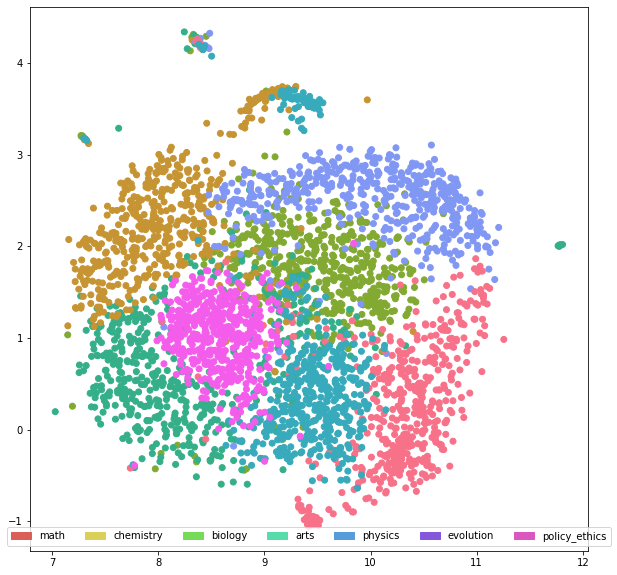

In [20]:
keys = list(articles["class"].value_counts().keys())
themes_dict = {keys[i]:i for i in range(len(keys))}
colors = [sns.color_palette("husl", len(themes_dict))[x] for x in articles["class"].map(themes_dict)]

fig = plt.figure(figsize=(10, 10))
plt.scatter(umap_result[:, 0], umap_result[:, 1], c=colors)

patches = [mpatches.Patch(color=sns.color_palette("hls", len(themes_dict))[i], label=keys[i]) for i in range(len(keys))]
plt.legend(handles=patches, ncol=10, loc="lower center")

Преобразуем тексты в виде n-грамм в последовательности индексов слов в матрице вложений:

In [195]:
x_train = kprocessing.sequence.pad_sequences(
    train.vec, 
    maxlen=max_words, 
    padding="post", 
    truncating="post"
)

Составляем n-граммы для тестовой выборки:

In [198]:
# Выравнивание по длине
x_test = kprocessing.sequence.pad_sequences(
    test.vec, 
    maxlen=max_words,
    padding="post", 
    truncating="post"
)

Строим матрицу вложений размером <число_слов> * <длина_вложения_слова>:

In [ ]:
embeddings = np.zeros((len(dic_vocabulary) + 1, 50))
for word,idx in dic_vocabulary.items():
    # Заполняем каждую строку вложением слова с соответсвующим индексом
    try:
        embeddings[idx] =  nlp[word]
    except:
        pass

In [132]:
max_words = max(articles.vec.apply(lambda vec: len(vec)))
num_classes = 7

In [144]:
model = Sequential()
model.add(layers.Dense(512, input_shape=(max_words,)))
model.add(layers.Activation('relu'))
model.add(layers.Dense(num_classes))
model.add(layers.Activation('softmax'))
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 512)               39373312  
_________________________________________________________________
activation_6 (Activation)    (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 7)                 3591      
_________________________________________________________________
activation_7 (Activation)    (None, 7)                 0         
Total params: 39,376,903
Trainable params: 39,376,903
Non-trainable params: 0
_________________________________________________________________


In [206]:
y_train = train["class"].values
dic_y_mapping = {n:label for n,label in 
                 enumerate(np.unique(y_train))}
inverse_dic = {v:k for k,v in dic_y_mapping.items()}
y_train = np.array([inverse_dic[y] for y in y_train])

y_test = test["class"].values
dic_y_mapping = {n:label for n,label in 
                 enumerate(np.unique(y_test))}
inverse_dic = {v:k for k,v in dic_y_mapping.items()}
y_test = np.array([inverse_dic[y] for y in y_test])

In [202]:
training = model.fit(x=x_train, y=y_train, batch_size=256, 
                     epochs=20, shuffle=True, verbose=0, 
                     validation_split=0.3)

In [207]:
res = list(map(lambda x: list(x).index(max(x)), model.predict(x_test)))
print(classification_report(y_test, res))

              precision    recall  f1-score   support

           0       0.75      0.77      0.76        92
           1       0.60      0.84      0.70        82
           2       0.78      0.72      0.75       102
           3       0.90      0.84      0.87       120
           4       0.81      0.90      0.85       107
           5       0.65      0.52      0.58        99
           6       0.73      0.65      0.69        98

    accuracy                           0.75       700
   macro avg       0.75      0.75      0.74       700
weighted avg       0.76      0.75      0.75       700

